**Цель работы:** 
- реализация собственных классов совместимых с библиотекой sklearn
- использование полиномиальной транcформации в моделях регрессии и классификации
- использование регуляризации в моделях регрессии и классификации
- выбор гиперпараметров и интерпретация кривых обучения

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import is_regressor 
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [2]:
FILE_PATH = "Reg_A5.csv"

## Задание 1. Реализация собственных классов и функций

In [3]:
df1 = pd.read_csv(FILE_PATH)
df1

,X,Y
0,3.856603,9.209759
1,0.103760,10.409240
2,3.168241,7.643742
3,3.744019,8.453341
4,2.492535,9.317824
...,...,...
295,4.403960,9.510032
296,3.004771,8.615320
297,3.226139,8.320160
298,0.283141,10.217886


1. Реализуйте класс, предназначенный для оценки параметров линейной регрессии с регуляризацией совместимый с sklearn. Передаваемые параметры: 1) коэффициент регуляризации (alpha). Использовать метод наименьших квадратов с регуляризацией.


In [4]:
class CustomLinearRegression(BaseEstimator, RegressorMixin):
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
       # self.random_state = 0
      #  self.random_state = None
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_in_ = X.shape[1]
        X_ = np.c_[np.ones(X.shape[0]), X]
        X_X = X_.T @ X_
        X_y = X_.T @ y
        reg = self.alpha * np.eye(X.shape[1] + 1)
        #self.coef_ = np.linalg.inv(X_.T @ X_) @ X_.T @ y
        #self.coef_ = np.linalg.pinv(X_) @ y
        self.coef_ = np.linalg.lstsq(X_X.astype(float)+ reg.astype(float), X_y.astype(float), rcond=None)[0]
        return self

    def predict(self, X):
        check_is_fitted(self, 'coef_')
        X = check_array(X)
        X_ = np.c_[np.ones(X.shape[0]), X]
        return X_ @ self.coef_
    

In [5]:
model = CustomLinearRegression(alpha=0.1)
check_estimator(CustomLinearRegression(alpha=0.1))

In [6]:
is_regressor(CustomLinearRegression())

True

2. Реализуйте класс для стандартизации признаков в виде трансформации совместимый с sklearn. Передаваемые параметры: 1) has_bias (содержит ли матрица вектор единиц), 2) apply_mean (производить ли центровку)



In [7]:
class CustomStandardTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, has_bias=True, apply_mean=True):
        self.has_bias = has_bias
        self.apply_mean = apply_mean
    
    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        if self.has_bias==False:
            X = np.c_[np.ones(X.shape[0]), X]
        if self.apply_mean:
            self.mean_ = np.mean(X, axis=0)
        else:
            self.mean_ = np.zeros(X.shape[1])
        self.std_ = np.std(X, axis=0)
        if self.has_bias==False:
            X = X[:, 1:]
        return self
    
    def transform(self, X):
        X = check_array(X)
        if self.has_bias==False:
            X = np.concatenate((np.zeros((X.shape[0], 1)), X), axis=1)
        self.std_[self.std_ == 0] = 1
        X = X_std = (X - self.mean_) / self.std_
        if self.has_bias==False:
            X = X[:, 1:]
        return X
    def fit_transform(self, X, y=None):
        self.fit(X, y=None)
        return self.transform(X)

In [8]:
check_estimator(CustomStandardTransformer())

3. Использую класс Pipeline, выполнить обучение линейной регрессии для всего набора данных с коэффициентом регуляризации равным 0.01. Выведите значения параметров обученной модели. Отобразите исходные данные и график функции предсказания.

In [9]:
pipeline = Pipeline([
    ("addone", CustomStandardTransformer()),
    ("regressor", CustomLinearRegression(alpha=0.01))
])

In [10]:
# Обучение
x = np.array(df1["X"]).reshape(-1, 1)
# X_train на x из df[]
pipeline.fit(x, df1["Y"])

# Параметры модели
print(f'w = {pipeline.named_steps["regressor"].coef_}')

# Качество модели
print(f'R^2 = {pipeline.score(x, df1["Y"])}')

# Предсказание
y_test__pred = pipeline.predict(x)
y_test__pred[:5]

w = [ 9.44860607 -0.40381569]
R^2 = 0.22583050973120444


array([ 9.04274503, 10.11231788,  9.2389305 ,  9.07483179,  9.43150899])

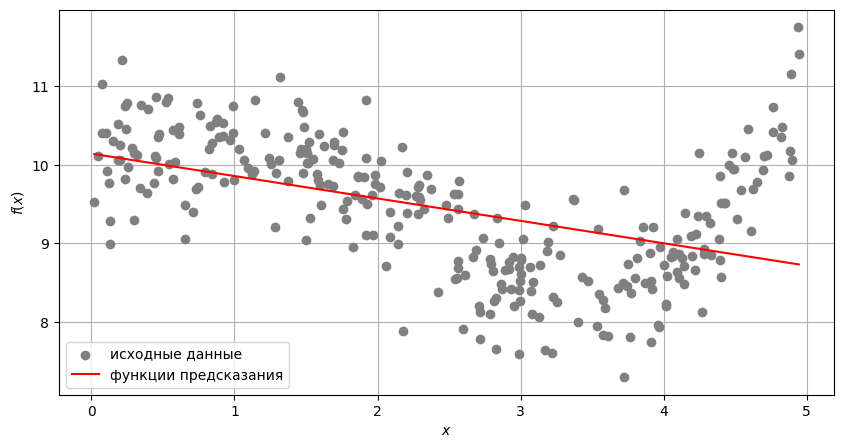

In [11]:
# Отображение наблюдений и линии регрессии
plt.figure(2, figsize=[10, 5])

xx = np.linspace(df1["X"].min(),df1["X"].max(), 2).reshape(-1,1)

plt.subplot(1,1,1)
plt.scatter(df1["X"], df1["Y"], color="grey", label="исходные данные", zorder=2)
plt.plot(xx, pipeline.predict(xx), "-", color="red", label="функции предсказания")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend()
plt.grid(True)

4. Реализуйте функции для расчета MSE и R^2 при отложенной выборке (run_holdout) и кросс-валидации (run_cross_val). Для кросс-валидации используйте только класс KFold. Выходными значениями должны быть MSE и R^2 для обучающей и тестовой частей.

In [12]:
import random
# функция для разбиения данных на обучающую и проверочную
def split(X, Y, train_size, random_state):
    random.seed(random_state)
    numbers = random.sample(range(len(X)), len(X))
    split_index = int(train_size * X.shape[0])
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(len(X)):
        if numbers[i] < split_index:
            X_train.append(X[i])
            y_train.append(Y[i])
        else:
            X_test.append(X[i])
            y_test.append(Y[i])

    return X_train, X_test, y_train, y_test

In [13]:
def run_holdout(model, X, y, train_size, random_state) -> dict:
    scores = {}
    X_train, X_test, y_train, y_test = split(X, y, train_size, random_state)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = (1/len(X_train))*(np.sum((y_train - y_train_pred)**2))
    mse_test  = (1/len(X_test))*(np.sum((y_test - y_test_pred)**2))
    scores['mse_train'] = mse_train
    scores['mse_test'] = mse_test

    r2_train = 1 - mse_train / np.var(y_train, ddof=1)
    r2_test = 1 - mse_test / np.var(y_test, ddof=1)
    scores['r2_train'] = r2_train
    scores['r2_test'] = r2_test
  
    return scores


def run_cross_val(model, X, y, n_splits, shuffle, random_state) -> dict:
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    scores = {}
    mse_train_list, mse_test_list, r2_train_list, r2_test_list = [], [], [], []
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        mse_train = (1/len(X_train))*(np.sum((y_train - y_train_pred)**2))
        mse_test = (1/len(X_test))*(np.sum((y_test - y_test_pred)**2))
        r2_train = 1 - mse_train / np.var(y_train, ddof=1)
        r2_test = 1 - mse_test / np.var(y_test, ddof=1)
        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)
    
    scores['mse_train'] = np.mean(mse_train_list)
    scores['mse_test'] = np.mean(mse_test_list)
    scores['r2_train'] = np.mean(r2_train_list)
    scores['r2_test'] = np.mean(r2_test_list)
    return scores


5. Выведите значения MSE и R^2, полученные посредством функций run_holdout и run_cross_val. Использовать следующие параметры:
 - train_size=0.75,
 - n_splits=4,
 - shuffle=True,
 - random_state=0

In [14]:
X=df1["X"]
y=df1["Y"]

In [15]:
train_size=0.75
n_splits=4
shuffle=True
random_state=0
X = np.array(X).reshape(-1, 1)
model1 = CustomLinearRegression(alpha=0.1)

In [16]:
a1= run_holdout(model1, X, y, train_size, random_state)
b1= run_cross_val(model1, X, y, n_splits, shuffle, random_state)

In [17]:
a1

{'mse_train': 0.519799212623774,
 'mse_test': 0.6898874667722752,
 'r2_train': 0.24236597309446906,
 'r2_test': 0.16637881991285874}

In [18]:
b1

{'mse_train': 0.558072293210556,
 'mse_test': 0.5665200777973177,
 'r2_train': 0.23089725223517393,
 'r2_test': 0.22847456191287543}

## Задание 2. Регрессия и кросс-валидация

Дано множество наблюдений (см. набор данных к заданию), модель - линейная регрессия (без регуляризации, с нормализацией). Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить среднеквадратическую ошибку на тестовом подмножестве (степень полинома от 1 до 25). Сделать заключение о влиянии степени полинома регуляризации.

**Построить:**
- диаграмму разброса исходных данных
- график зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств
- график зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств
- функцию регрессии (наилучший случай) + исходные данные

In [19]:
model3 = CustomStandardTransformer()
X= np.array(df1["X"]).reshape(-1, 1)
X = model3.fit_transform(X)

In [20]:
# исходные данные
degrees = np.arange(1, 26)
train_size=0.7
n_splits=4
shuffle=True
random_state=0
# train - обучающее, test - проверочное 
train_errors_holdout = []
test_errors_holdout = []
train_errors_cross_val = []
test_errors_cross_val = []
train_r2_holdout = []
test_r2_holdout = []
train_r2_cross_val = []
test_r2_cross_val = []
X_train, X_test, y_train, y_test = split(X, y, train_size, random_state)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [21]:
for degree in degrees:
    # Преобразование данных в полиномиальные признаки
    poly = PolynomialFeatures(degree=degree)
    
    X_poly = poly.fit_transform(X_train)

    # Обучение модели
    model4 = CustomLinearRegression(alpha=0)
    # Вычисление среднеквадратической ошибки на обучающей и тестовой выборках
    a1= run_holdout(model4, X_poly, y_train, train_size=0.75, random_state=0)
    b1= run_cross_val(model4, X_poly, y_train, n_splits=4, shuffle=True, random_state=0)
    train_errors_cross_val.append(b1['mse_train'])
  #  train_errors_holdout.append((1/len(X_train))*(np.sum((y_train - y_train_pred)**2)))
    train_errors_holdout.append(a1['mse_train'])
    test_errors_cross_val.append(b1['mse_test'])
   # test_errors_holdout.append((1/len(X_test))*(np.sum((y_test - y_test_pred)**2)))
    test_errors_holdout.append(a1['mse_test'])
    train_r2_holdout.append(a1['r2_train'])
    test_r2_holdout.append(a1['r2_test'])
    train_r2_cross_val.append(b1['r2_train'])
    test_r2_cross_val.append(b1['r2_test'])
    
# Определение степени полинома с минимальной ошибкой на тестовой выборке
min_test_error_index = np.argmin(test_errors_holdout)
min_test_error_degree = degrees[min_test_error_index]
#для CV min 
min_test_error_index_CV = np.argmin(test_errors_cross_val)
min_test_error_degree_CV = degrees[min_test_error_index_CV]
print(f"Степень полинома с минимальной ошибкой на проверочном подмножестве для отложенной выборки: {min_test_error_degree}")
print(f"Степень полинома с минимальной ошибкой на проверочном подмножестве для  кросс-валидации: {min_test_error_degree_CV}")
# Определение среднеквадратической ошибки на тестовой выборке для выбранной степени полинома
degree = min_test_error_degree
degree_CV = min_test_error_degree_CV

poly = PolynomialFeatures(degree=degree)
poly_CV = PolynomialFeatures(degree=degree_CV)

X_poly = poly.fit_transform(X)
X_poly_CV = poly_CV.fit_transform(X)

regressor = CustomLinearRegression(alpha=0)

a2= run_holdout(regressor, X_poly, y, train_size=0.75, random_state=0)
b2= run_cross_val(regressor, X_poly_CV, y, n_splits, shuffle, random_state)
test_error_holdout = a2['mse_test']
test_error_cross_val = b2['mse_test']

print(f"Среднеквадратическая ошибка на тестовом подмножестве для отложенной выборки: {test_error_holdout}")
print(f"Среднеквадратическая ошибка на тестовой подмножестве для кросс-валидации : {test_error_cross_val}")

Степень полинома с минимальной ошибкой на проверочном подмножестве для отложенной выборки: 12
Степень полинома с минимальной ошибкой на проверочном подмножестве для  кросс-валидации: 5
Среднеквадратическая ошибка на тестовом подмножестве для отложенной выборки: 0.2903874527288847
Среднеквадратическая ошибка на тестовой подмножестве для кросс-валидации : 0.23541169717922455


### Диаграмма разброса исходных данных

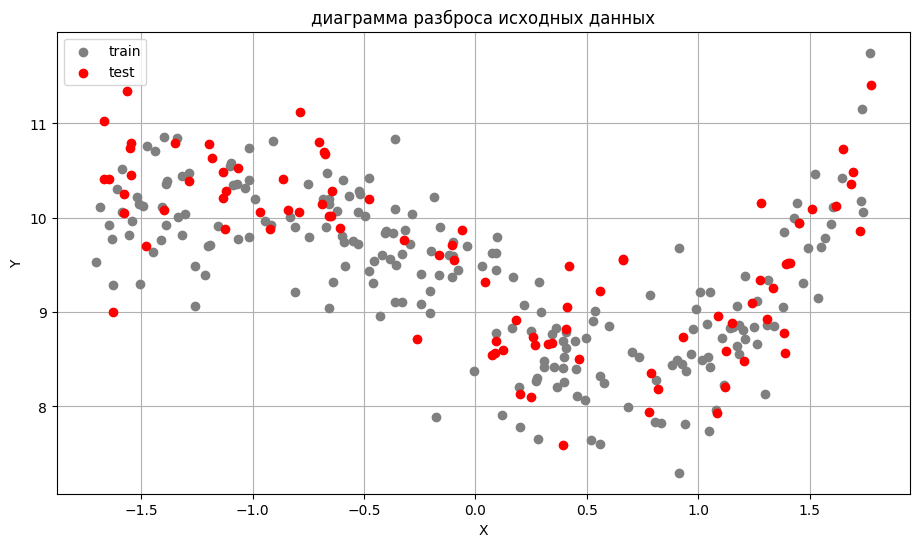

In [22]:
X_train, X_test, y_train, y_test = split(X, y, train_size, random_state)
# Отображение наблюдений и линии регрессии
plt.figure(2, figsize=[11, 6])
#xx = np.linspace(df1["X"].min(),df1["X"].max(), 2).reshape(-1,1)
plt.title("диаграмма разброса исходных данных")
plt.subplot(1,1,1)
plt.scatter(X_train, y_train, color="grey", label="train", zorder=2)
plt.scatter(X_test, y_test, color="red", label="test", zorder=2)
#plt.plot(xx, pipeline.predict(xx), "-", color="grey", label="Regression")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

### График зависимости среднеквадратической ошибки (MSE) от степени полинома для обучающего и проверочного подмножеств 
### График зависимости коэффициента детерминации (R^2) от степени полинома для обучающего и проверочного подмножеств

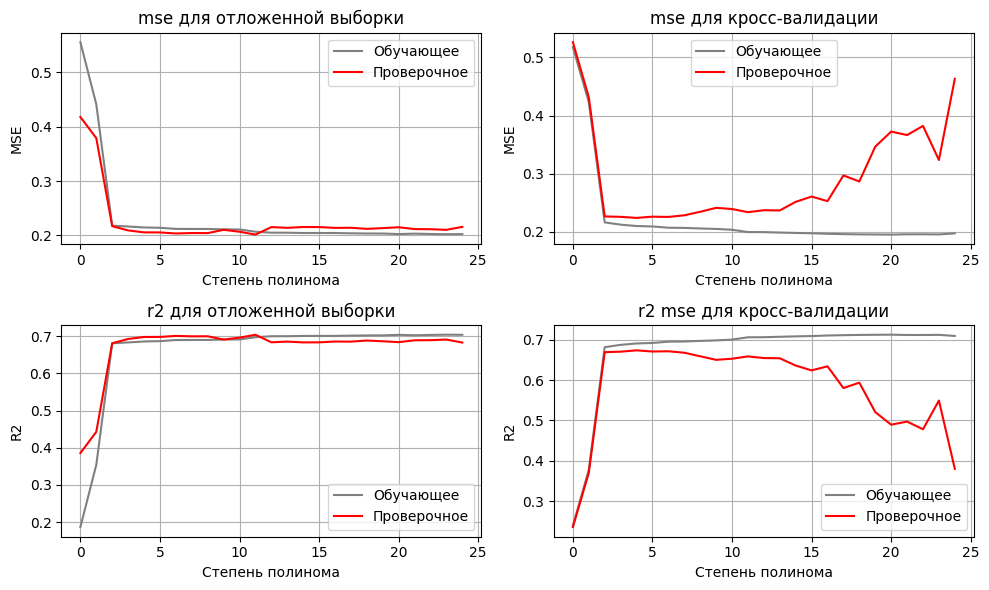

In [23]:
# Корректировка расположения
plt.figure("2",figsize=[10, 6])

plt.subplot(2,2,1)
plt.title("mse для отложенной выборки")
plt.plot(train_errors_holdout, "-", color="grey", label="Обучающее")
plt.plot(test_errors_holdout, "-", color="red", label="Проверочное")
plt.xlabel("Степень полинома")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)

plt.title("mse для кросс-валидации")
plt.plot(train_errors_cross_val, "-", color="grey", label="Обучающее")
plt.plot(test_errors_cross_val, "-", color="red", label="Проверочное")
plt.xlabel("Степень полинома")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.title("subplot 2 2 3")
plt.title("r2 mse для кросс-валидации")
plt.plot(train_r2_cross_val, "-", color="grey", label="Обучающее")
plt.plot(test_r2_cross_val, "-", color="red", label="Проверочное")
plt.xlabel("Степень полинома")
plt.ylabel("R2")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.title("r2 для отложенной выборки")
plt.plot(train_r2_holdout, "-", color="grey", label="Обучающее")
plt.plot(test_r2_holdout, "-", color="red", label="Проверочное")
plt.xlabel("Степень полинома")
plt.ylabel("R2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Заключение о влиянии степени полинома регуляризации:

Степень полинома с минимальной ошибкой на проверочном подмножестве для отложенной выборки: 12

Степень полинома с минимальной ошибкой на проверочном подмножестве для  кросс-валидации: 5

В начале MSE уменьшается быстро. После степени полинома = 3 MSE уменьшается понемногу

Можно заметить, что до степени полинома = 5 при кросс-валидации среднеквадратическая ошибка уменьшается, после 5 начинает возрастать.

Можно заметить, что до степени полинома = 12 при отложенной выборке среднеквадратическая ошибка уменьшается, после 12 начинает возрастать.

### Функция регрессии (наилучший случай) + исходные данные

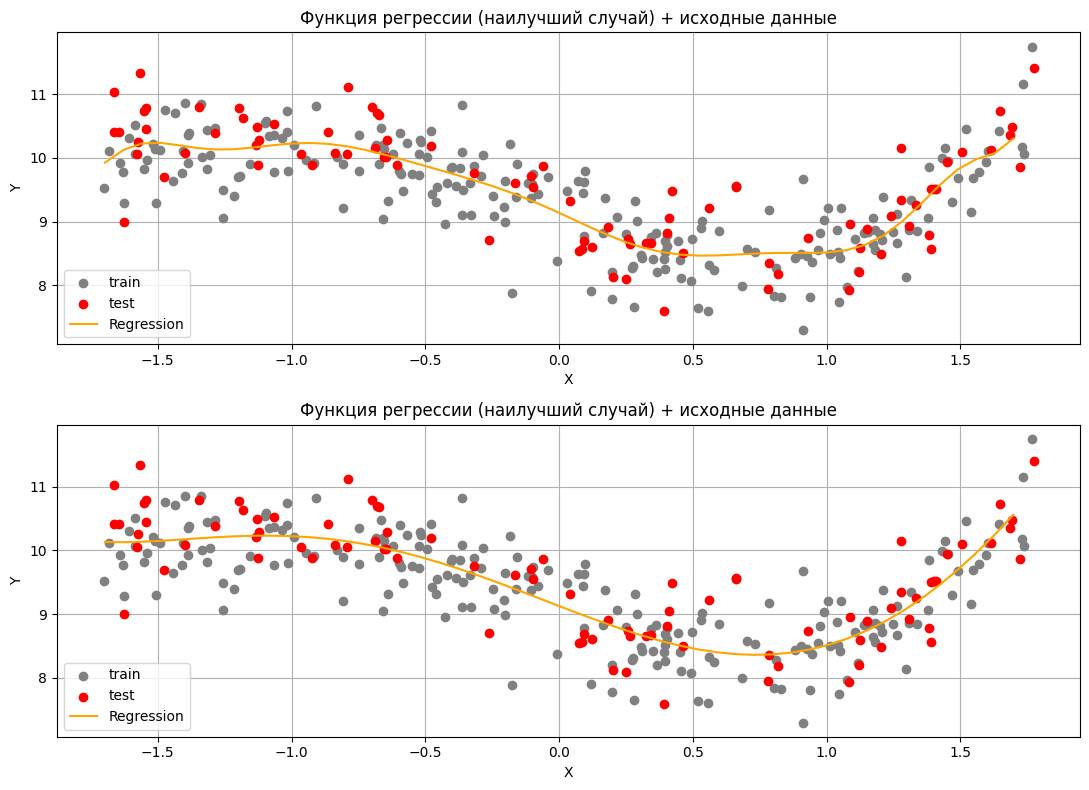

In [24]:
X_train, X_test, y_train, y_test = split(X, y, train_size, random_state)
poly = PolynomialFeatures(degree=degree)
poly_CV = PolynomialFeatures(degree=degree_CV)

X_poly = poly.fit_transform(X)
X_poly_CV = poly_CV.fit_transform(X)

regressor.fit(X_poly, y)
xx = np.linspace(X.min(),X.max()).reshape(-1,1)
xx = model3.fit_transform(xx)
X_pred = poly.fit_transform(xx)
regressor1 = CustomLinearRegression(alpha=0)
regressor1.fit(X_poly_CV, y)
xx_CV = np.linspace(X.min(),X.max()).reshape(-1,1)
xx_CV = model3.fit_transform(xx_CV)
X_pred_CV = poly_CV.fit_transform(xx_CV)
# Отображение наблюдений и линии регрессии
plt.figure("2",figsize=[11, 8])
plt.subplot(2,1,1)
plt.title("Функция регрессии (наилучший случай) + исходные данные")
plt.scatter(X_train, y_train, color="grey", label="train", zorder=2)
plt.scatter(X_test, y_test, color="red", label="test", zorder=2)
plt.plot(xx, regressor.predict(X_pred), "-", color="orange", label="Regression")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.title("Функция регрессии (наилучший случай) + исходные данные")
plt.scatter(X_train, y_train, color="grey", label="train", zorder=2)
plt.scatter(X_test, y_test, color="red", label="test", zorder=2)
plt.plot(xx_CV, regressor1.predict(X_pred_CV), "-", color="orange", label="Regression")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Задание 3. Классификация и кросс-валидация

Дано множество наблюдений (см. набор данных к заданию), классификатор - логистическая регрессия. Найти степень полинома с минимальной ошибкой на проверочном подмножестве, определить долю правильных классификаций на тестовом подмножестве. Сделать заключение о влиянии степени полинома регуляризации.

**Построить:**

- диаграмму разброса исходных данных
- график зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств
- график зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая
- результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств

In [25]:
surname = "Горский"  # Ваша фамилия

alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alph, w))
variant =  sum([d[el] for el in surname.lower()]) % 2 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  1


In [26]:
FILE_PATH = "Cl_A5_V1.csv"
df3 = pd.read_csv(FILE_PATH)
df3

,X1,X2,Y
0,11.145485,4.790697,0
1,3.094885,4.787600,1
2,8.577163,3.914841,0
3,9.427682,5.266742,0
4,3.514624,6.213900,1
...,...,...,...
495,8.541672,7.783972,0
496,1.163040,3.720493,1
497,5.230271,3.757211,1
498,6.051527,4.859310,0


### Диаграмма разброса исходных данных

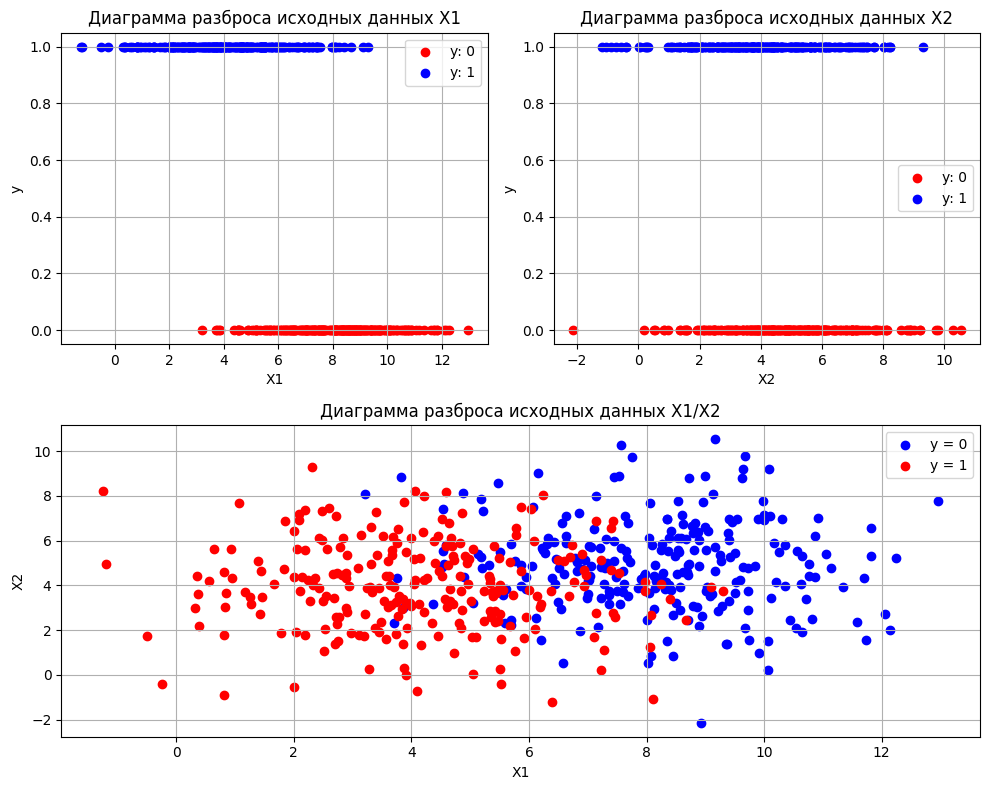

In [27]:
# График
X =df3.drop('Y', axis=1)
X = np.array(X)
y = np.array(df3["Y"])
X1 = np.array(df3["X1"])
X2 = np.array(df3["X2"])

# Корректировка расположения
plt.figure("2",figsize=[10, 8])
y_one_indx = np.argwhere(y == 1).flatten()
y_zero_indx =  np.argwhere(y == 0).flatten()

plt.subplot(2,1,2)
plt.title("Диаграмма разброса исходных данных X1/X2")
plt.scatter(X[y_zero_indx][:,0], X[y_zero_indx][:,1], color="blue", label="y = 0")
plt.scatter(X[y_one_indx][:,0], X[y_one_indx][:,1], color="red", label="y = 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()

y_one_indx = np.argwhere(y==1)
y_zero_indx =  np.argwhere(y==0)

plt.subplot(2,2,1)
plt.title("Диаграмма разброса исходных данных X1")
plt.scatter(X1[y_zero_indx], y[y_zero_indx], color="red", label="y: 0")
plt.scatter(X1[y_one_indx], y[y_one_indx], color="blue", label="y: 1")
plt.xlabel("X1")
plt.ylabel("y")
plt.legend()
plt.grid(True)


plt.subplot(2,2,2)
plt.title("Диаграмма разброса исходных данных X2")
plt.scatter(X2[y_zero_indx], y[y_zero_indx], color="red", label="y: 0")
plt.scatter(X2[y_one_indx], y[y_one_indx], color="blue", label="y: 1")
plt.xlabel("X2")
plt.ylabel("y")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [28]:
# Обучение
logistic_model = LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=100, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)
#X=np.array(df3["X1"]).reshape(-1, 1)
X =df3.drop('Y', axis=1)
logistic_model.fit(X, df3["Y"])

# Параметры обученной модели
print("Параметры модели:")
print("\tw{} = {}".format(0, logistic_model.intercept_[0]))
for indx, coef in enumerate(logistic_model.coef_.flatten()):
    print("\tw{} = {}".format(indx+1, coef))

Параметры модели:
	w0 = 8.195041078440635
	w1 = -1.0751460132888464
	w2 = -0.35281912402053156


In [29]:
# Формирование обучающего и тестового подмножеств
X =df3.drop('Y', axis=1)
X = np.array(X)
X_train_, X_test_, y_train_, y_test_ = split(X, df3["Y"], train_size=0.7, random_state=0)

y_train_ = pd.Series(y_train_)
y_test_ = pd.Series(y_test_)
X_train_ = np.array(X_train_)
X_test_ = np.array(X_test_)
# X_train, y_train - обучающее подмножество, X_test, y_test - проверочное подмножество
X_train, X_test, y_train, y_test = split(X_train_, y_train_, train_size=0.7, random_state=0)

In [30]:
# реализация функции для оценки модели с отложенной выборкой 
def score_ac(y_test, y_pred):
    n=0
    for i in range(len(y_test)): 
        if y_test[i] == y_pred[i]:
             n+=1
        
    return n/len(y_test)

In [31]:
degrees = np.arange(1, 26)
train_errors_cross_val= []
test_errors_cross_val= []
test_errors_holdout = []
train_errors_holdout= []
accuracy=[]
for degree in degrees:
    # Преобразование данных в полиномиальные признаки
    poly = PolynomialFeatures(degree=degree)
    
    X_poly = poly.fit_transform(X_train)
    
    #test
    X_poly_test = poly.fit_transform(X_test)

    # Обучение модели
    model4 =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=100, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)
    cv_results = cross_validate(model4, X_poly, y_train, cv=4)
    train_errors_cross_val.append(cv_results['test_score'].mean())
    
    #test
    cv_results_test = cross_validate(model4, X_poly_test, y_test, cv=4)
    test_errors_cross_val.append(cv_results_test['test_score'].mean())
    
    
    # Создание объекта логистической регрессии
    logreg =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=100, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)

    # Обучение модели на обучающей выборке
    logreg.fit(X_poly, y_train)

    # Предсказание меток классов для тестовой выборки
    y_pred = logreg.predict(X_poly)
    train_errors_holdout.append(score_ac(y_train, y_pred))
    
    
    
    #test
    logreg.fit(X_poly_test, y_test)
    y_pred_hold = logreg.predict(X_poly_test)
    test_errors_holdout.append(score_ac(y_test, y_pred_hold))
    
#Определение степени полинома с минимальной ошибкой на тестовой выборке
max_test_error_index = np.argmax(test_errors_cross_val)
max_test_error_degree = degrees[max_test_error_index]



max_accuracy = np.argmax(test_errors_holdout)
max_accuracy_degree = degrees[max_accuracy]

print(f"Степень полинома с минимальной ошибкой на проверочном подмножестве с кросс-валидацией: {max_test_error_degree}")
print(f"Степень полинома с минимальной ошибкой на проверочном подмножестве с отложенной выборкой: {max_accuracy_degree}")

degree = max_test_error_degree
degree_hold = max_accuracy_degree


poly = PolynomialFeatures(degree=degree)
poly_hold = PolynomialFeatures(degree=degree_hold)


X_poly = poly.fit_transform(X_test_)
X_poly_hold = poly_hold.fit_transform(X_test_)


model4 =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=100, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)
cv_results = cross_validate(model4, X_poly, y_test_, cv=4)
test_error_cross_val= cv_results['test_score'].mean()



# Создание объекта логистической регрессии
logreg =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=100, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)
# Обучение модели на обучающей выборке
logreg.fit(X_poly_hold, y_test_)

# Предсказание меток классов для тестовой выборки
y_pred = logreg.predict(X_poly_hold)

# Вычисление точности модели на тестовой выборке
accuracy = score_ac(y_test_, y_pred)

print(f"Доля правильных классификаций на тестовом подмножестве с кросс-валидацией: {test_error_cross_val*100}%")
print(f"Доля правильных классификаций на тестовом подмножестве с отложенной выборкой: {accuracy*100}%")

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Степень полинома с минимальной ошибкой на проверочном подмножестве с кросс-валидацией: 1
Степень полинома с минимальной ошибкой на проверочном подмножестве с отложенной выборкой: 1
Доля правильных классификаций на тестовом подмножестве с кросс-валидацией: 86.61095305832148%
Доля правильных классификаций на тестовом подмножестве с отложенной выборкой: 88.0%


### График зависимости доли правильных классификаций от степени полинома для обучающего и проверочного подмножеств

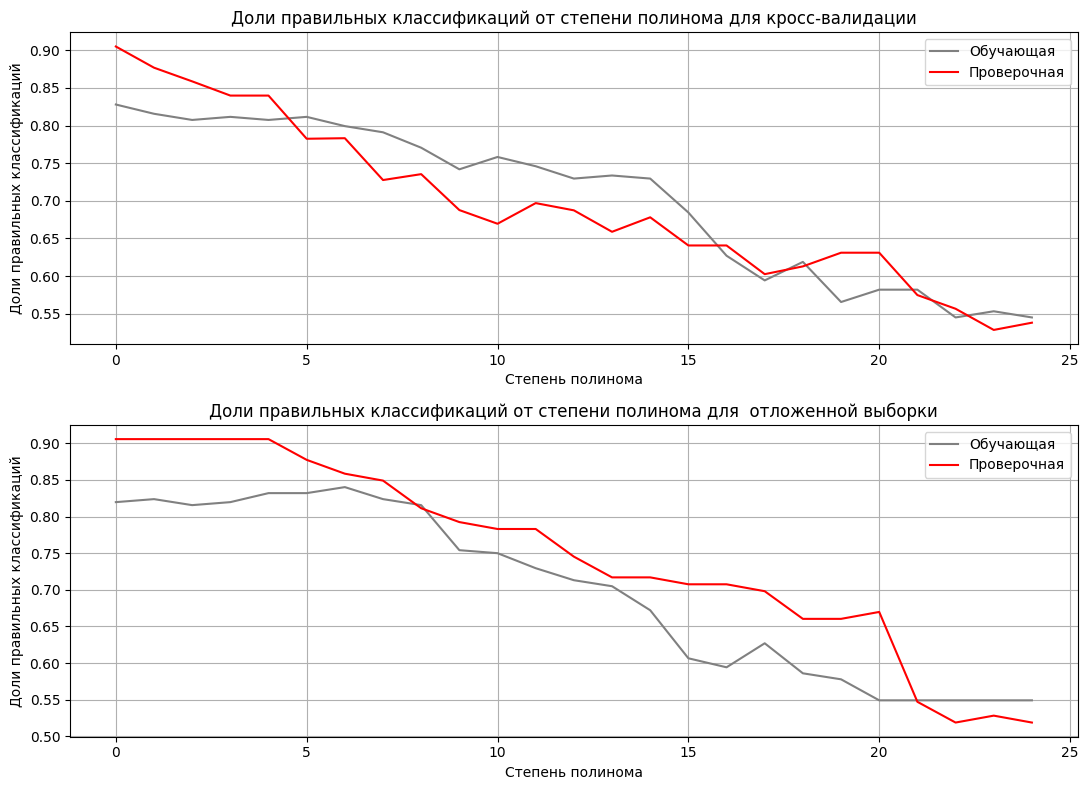

In [32]:
# Корректировка расположения
plt.figure("2",figsize=[11, 8])

plt.subplot(2,1,1)
plt.title("Доли правильных классификаций от степени полинома для кросс-валидации")
plt.plot(train_errors_cross_val, "-", color="grey", label="Обучающая")
plt.plot(test_errors_cross_val, "-", color="red", label="Проверочная")
plt.xlabel("Степень полинома")
plt.ylabel("Доли правильных классификаций")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.title("Доли правильных классификаций от степени полинома для  отложенной выборки")
plt.plot(train_errors_holdout, "-", color="grey", label="Обучающая")
plt.plot(test_errors_holdout, "-", color="red", label="Проверочная")
plt.xlabel("Степень полинома")
plt.ylabel("Доли правильных классификаций")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Заключение о влиянии степени полинома регуляризации:

Степень полинома с минимальной ошибкой на проверочном подмножестве с кросс-валидацией: 1

Степень полинома с минимальной ошибкой на проверочном подмножестве с отложенной выборкой: 1

Можно заметить, что до степени полинома = 1 при кросс-валидации доля правильных классификаций растет, после 1 начинает падать.

Можно заметить, что до степени полинома = 1 прио тложенной выборке доля правильных классификаций растет, после 1 начинает падать.

### График зависимости доли правильных классификаций от количества итераций для обучающего и проверочного подмножеств для наилучшего случая

In [33]:
poly = PolynomialFeatures(degree=degree)
poly_hold = PolynomialFeatures(degree=degree_hold)

X_poly_CV_train = poly.fit_transform(X_train)
X_poly_CV_test = poly.fit_transform(X_test)
X_poly_hold_train = poly_hold.fit_transform(X_train)
X_poly_hold_test = poly_hold.fit_transform(X_test)
train_errors_cross_val_iter=[]
test_errors_cross_val_iter=[]
train_errors_holdout_iter=[]
test_errors_holdout_iter=[]

iters = np.arange(1, 100)
for iter_ in iters:
    # Обучение модели
    model4 =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=iter_, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)
    cv_results = cross_validate(model4, X_poly_CV_train, y_train, cv=4)
    train_errors_cross_val_iter.append(cv_results['test_score'].mean())
    
    #test
    cv_results_test = cross_validate(model4, X_poly_CV_test, y_test, cv=4)
    test_errors_cross_val_iter.append(cv_results_test['test_score'].mean())
    
    
    # Создание объекта логистической регрессии
    logreg =LogisticRegression(penalty='l2', fit_intercept=True, 
                                    max_iter=iter_, 
                                    C=1e5, 
                                    solver='liblinear', 
                                    random_state=12345)

    # Обучение модели на обучающей выборке
    logreg.fit(X_poly_hold_train, y_train)

    # Предсказание меток классов для тестовой выборки
    y_pred = logreg.predict(X_poly_hold_train)
    train_errors_holdout_iter.append(score_ac(y_train, y_pred))
    
    
    
    #test
    logreg.fit(X_poly_hold_test, y_test)
    y_pred_hold = logreg.predict(X_poly_hold_test)
    test_errors_holdout_iter.append(score_ac(y_test, y_pred_hold))
    

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

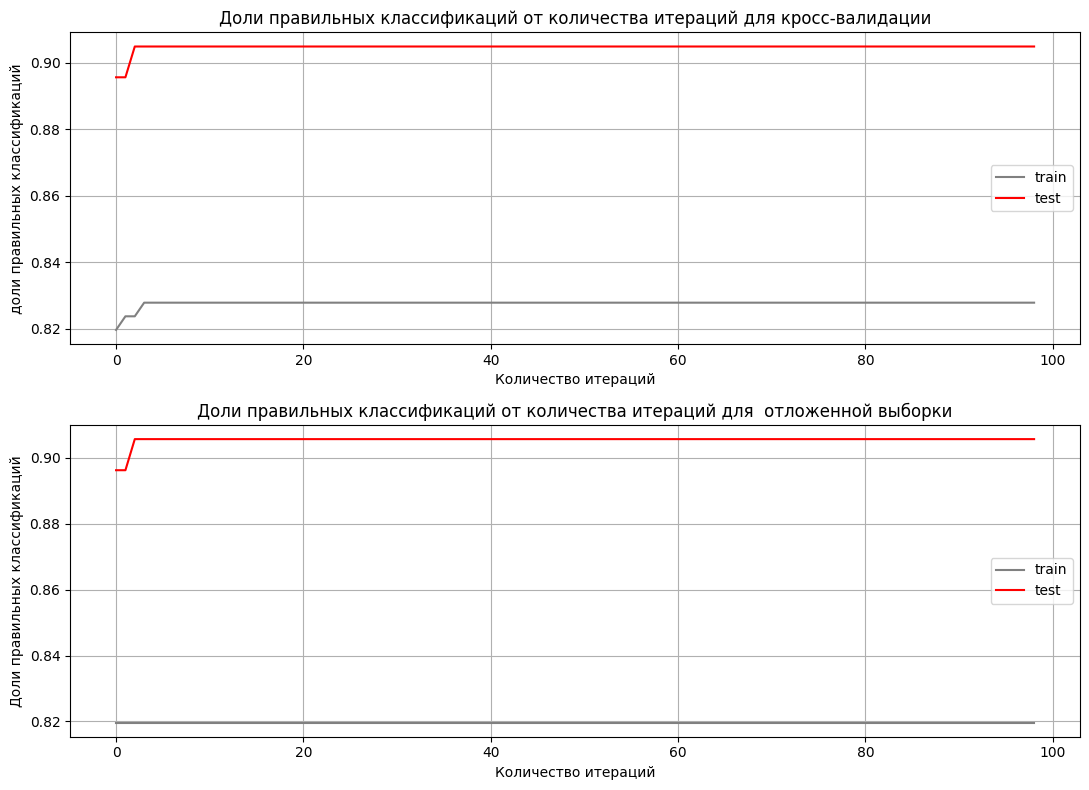

In [34]:
# Корректировка расположения
plt.figure("2",figsize=[11, 8])

plt.subplot(2,1,1)
plt.title("Доли правильных классификаций от количества итераций для кросс-валидации")
plt.plot(train_errors_cross_val_iter, "-", color="grey", label="train")
plt.plot(test_errors_cross_val_iter, "-", color="red", label="test")
plt.xlabel("Количество итераций")
plt.ylabel("доли правильных классификаций")
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.title("Доли правильных классификаций от количества итераций для  отложенной выборки")
plt.plot(train_errors_holdout_iter, "-", color="grey", label="train")
plt.plot(test_errors_holdout_iter, "-", color="red", label="test")
plt.xlabel("Количество итераций")
plt.ylabel("Доли правильных классификаций")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Результат классификации для наилучшего случая (степень полинома) для обучающего и тестового подмножеств

In [35]:
# Формирование обучающего и тестового подмножеств
X =df3.drop('Y', axis=1)
X = np.array(X)

X_train_, X_test_, y_train_, y_test_ = split(X, df3["Y"], train_size=0.7, random_state=0)

y_train_ = pd.Series(y_train_)
y_test_ = pd.Series(y_test_)
X_train_ = np.array(X_train_)
X_test_ = np.array(X_test_)
# X_train, y_train - обучающее подмножество, X_test, y_test - проверочное подмножество
X_train, X_test, y_train, y_test = split(X_train_, y_train_, train_size=0.7, random_state=0)

poly = PolynomialFeatures(degree=degree)

X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test_)

logreg = LogisticRegression(penalty='l2', fit_intercept=True, 
                            max_iter=100, 
                            C=1e5, 
                            solver='liblinear', 
                            random_state=12345)
logreg.fit(X_poly_train, y_train)


y_pred_train = logreg.predict(X_poly_train)
y_pred_test = logreg.predict(X_poly_test)

arr_concatenated = np.concatenate(X_train)
arr_concatenated1 = np.concatenate(X_test_)
X_train = arr_concatenated.reshape((len(X_train), 2))
X_test = arr_concatenated1.reshape((len(X_test_), 2))

### График с кросс-валидацией

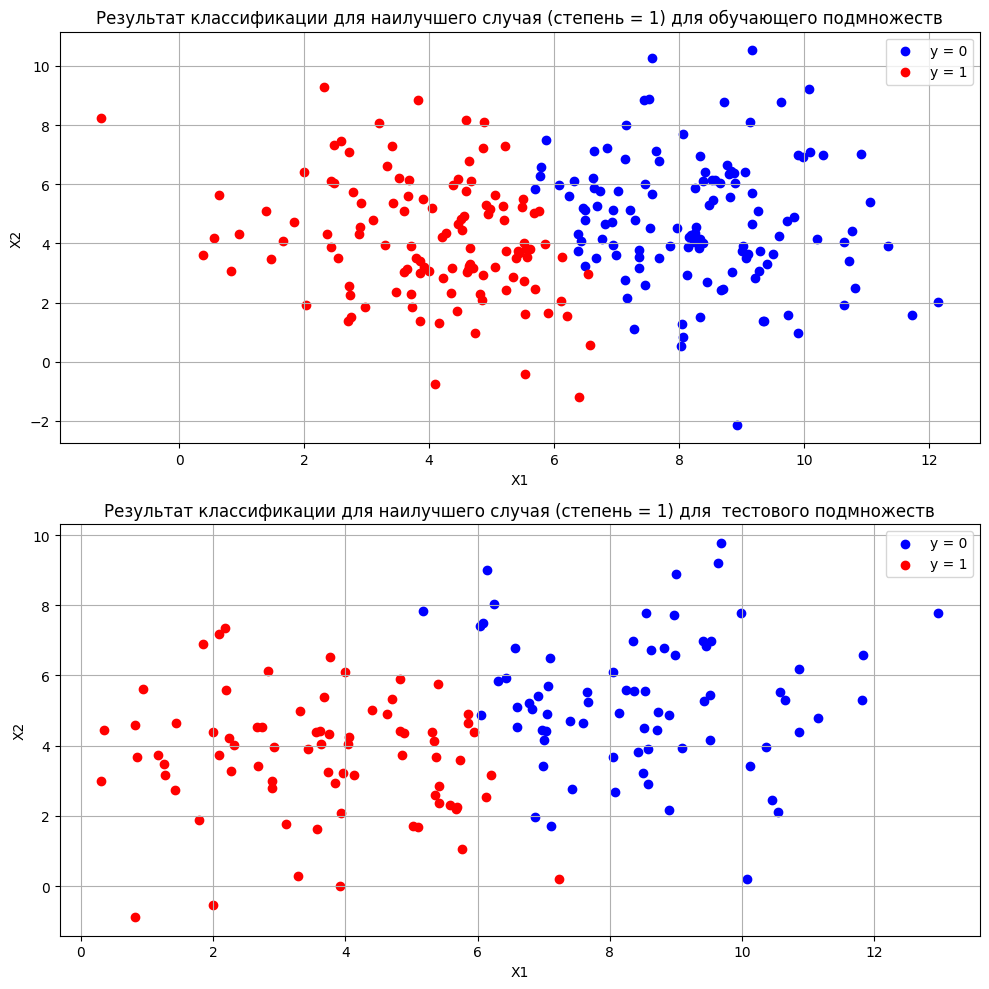

In [36]:
# График
X =df3.drop('Y', axis=1)
X = np.array(X)

# Корректировка расположения
plt.figure("2",figsize=[10, 10])
y_one_indx = np.argwhere(y_pred_train == 1).flatten()
y_zero_indx =  np.argwhere(y_pred_train == 0).flatten()
y_one_indx_test = np.argwhere(y_pred_test == 1).flatten()
y_zero_indx_test =  np.argwhere(y_pred_test == 0).flatten()

plt.subplot(2,1,1)
plt.title(f"Результат классификации для наилучшего случая (степень = {degree}) для обучающего подмножеств")
plt.scatter(X_train[y_zero_indx][:,0], X_train[y_zero_indx][:,1], color="blue", label="y = 0")
plt.scatter(X_train[y_one_indx][:,0], X_train[y_one_indx][:,1], color="red", label="y = 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title(f"Результат классификации для наилучшего случая (степень = {degree}) для  тестового подмножеств")
plt.scatter(X_test_[y_zero_indx_test][:,0], X_test[y_zero_indx_test][:,1], color="blue", label="y = 0")
plt.scatter(X_test_[y_one_indx_test][:,0], X_test[y_one_indx_test][:,1], color="red", label="y = 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
poly = PolynomialFeatures(degree=degree_hold)
X =df3.drop('Y', axis=1)
X = np.array(X)


X_train_, X_test_, y_train_, y_test_ = split(X, df3["Y"], train_size=0.7, random_state=0)

y_train_ = pd.Series(y_train_)
y_test_ = pd.Series(y_test_)
X_train_ = np.array(X_train_)
X_test_ = np.array(X_test_)
# X_train, y_train - обучающее подмножество, X_test, y_test - проверочное подмножество
X_train, X_test, y_train, y_test = split(X_train_, y_train_, train_size=0.7, random_state=0)


X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test_)

logreg = LogisticRegression(penalty='l2', fit_intercept=True, 
                            max_iter=100, 
                            C=1e5, 
                            solver='liblinear', 
                            random_state=12345)
logreg.fit(X_poly_train, y_train)

y_pred_train = logreg.predict(X_poly_train)
y_pred_test = logreg.predict(X_poly_test)

arr_concatenated = np.concatenate(X_train)
arr_concatenated1 = np.concatenate(X_test_)
X_train = arr_concatenated.reshape((len(X_train), 2))
X_test = arr_concatenated1.reshape((len(X_test_), 2))

### График с отложенной выборкой

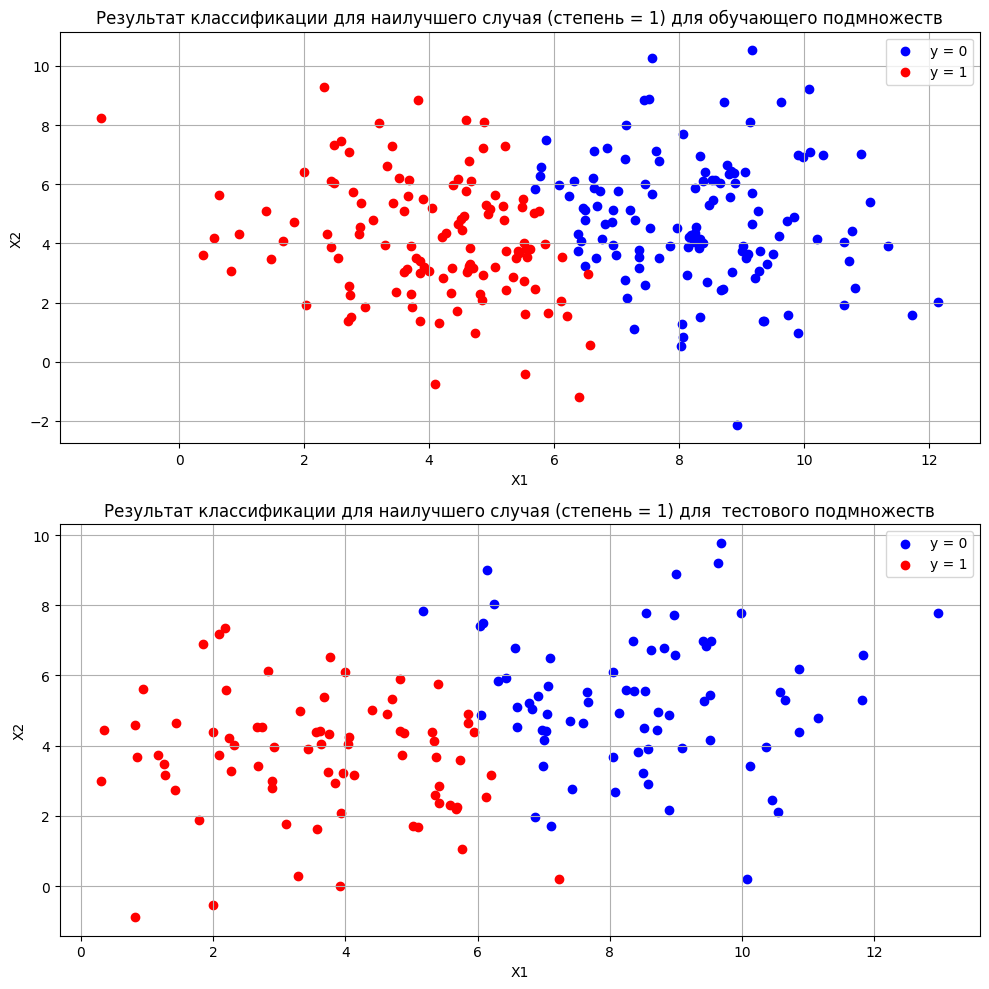

In [38]:

# Корректировка расположения
plt.figure("2",figsize=[10, 10])
y_one_indx = np.argwhere(y_pred_train == 1).flatten()
y_zero_indx =  np.argwhere(y_pred_train == 0).flatten()
y_one_indx_test = np.argwhere(y_pred_test == 1).flatten()
y_zero_indx_test =  np.argwhere(y_pred_test == 0).flatten()

plt.subplot(2,1,1)
plt.title(f"Результат классификации для наилучшего случая (степень = {degree_hold}) для обучающего подмножеств")
plt.scatter(X_train[y_zero_indx][:,0], X_train[y_zero_indx][:,1], color="blue", label="y = 0")
plt.scatter(X_train[y_one_indx][:,0], X_train[y_one_indx][:,1], color="red", label="y = 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()

plt.subplot(2,1,2)
plt.title(f"Результат классификации для наилучшего случая (степень = {degree_hold}) для  тестового подмножеств")
plt.scatter(X_test_[y_zero_indx_test][:,0], X_test[y_zero_indx_test][:,1], color="blue", label="y = 0")
plt.scatter(X_test_[y_one_indx_test][:,0], X_test[y_one_indx_test][:,1], color="red", label="y = 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()